In [13]:
import itertools
import os
import sys

from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import cifar10
from keras.layers import Add, AveragePooling2D, BatchNormalization, Concatenate, Conv2D, Dense, Input, Lambda, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
# debugging
# K.set_session(tf_debug.TensorBoardDebugWrapperSession(K.get_session(),
#                                                       'localhost:6064',
#                                                       send_traceback_and_source_code=False))

In [14]:
def decode(serialized_example):
    """Parses an image and label from the given `serialized_example`."""
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length 250 * 250) to a float64 tensor with shape
    # [250 * 250].
    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [64, 512, 1])
    
    # Remove NaN
    image = tf.where(tf.is_nan(image), tf.zeros_like(image), image)
    
    # Normalize image     
    image = (image + 0.49) * 500 + 4.5
    
    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int64)
    
    return image, label

In [15]:
def translate(image, label, num_samples=5, num_quantums=16):
    transformed_images = []
    translate_vectors = []
    
    for _ in range(num_samples):
        translation_index = np.random.randint(0, num_quantums)
        translation = translation_index * (512 // num_quantums)
        transformed_images.append(
            tf.concat([image[:, translation:], 
                       image[:, :translation]], 1))
        translate_vector = np.zeros(num_quantums, np.uint16)
        translate_vector[translation_index] = 1
        translate_vector = tf.convert_to_tensor(translate_vector)
        translate_vectors.append(translate_vector)
    
    images = tf.stack([image] * num_samples)
    labels = tf.stack([label] * num_samples)
    transformed_images = tf.stack(transformed_images)
    translate_vectors = tf.stack(translate_vectors)
    
    return images, labels, transformed_images, translate_vectors

In [16]:
translate_lambda = lambda image, lable: translate(image, label)

In [17]:
def inputs(sess, file_pattern, batch_size, num_epochs):
    """Reads input data num_epochs times.
    Args:
    batch_size: Number of examples per returned batch.
    num_epochs: Number of times to read the input data, or 0/None to
       train forever.
    Returns:
    A tuple (images, labels), where:
    * images is a float tensor with shape [batch_size, 350, 250]
      in the range [-0.5, 0.5].
    * labels is an int64 tensor with shape [batch_size] with the true label.

    This function creates a one_shot_iterator, meaning that it will only iterate
    over the dataset once. On the other hand there is no special initialization
    required.
    """
    if not num_epochs:
        num_epochs = None

    with tf.name_scope('input'):
        # Load multiple files by pattern
        files = tf.data.Dataset.list_files(file_pattern)
        
        dataset = files.apply(tf.contrib.data.parallel_interleave(
                                lambda filename: tf.data.TFRecordDataset(filename),
                                cycle_length=4, 
                                block_length=4,
                                buffer_output_elements=batch_size))
        
        # Shuffle 500 elements at a time         
        dataset = dataset.apply(
                        tf.contrib.data.shuffle_and_repeat(3 * batch_size, num_epochs))
        
        # Create batch and decode
#                          .map(translate, num_parallel_calls=4)\
#                          .apply(tf.contrib.data.unbatch())\
        dataset = dataset.map(decode, num_parallel_calls=4)\
                         .shuffle(batch_size * 5)\
                         .batch(batch_size)\
                         .prefetch(batch_size)

        iterator = dataset.make_one_shot_iterator()

        while True:
#             image, label, transformed_image, translate_vector = iterator.get_next()
#             image, label, transformed_image, translate_vector = sess.run([image, label, transformed_image, translate_vector])
#             yield ([image, translate_vector], transformed_image)
            image, _ = iterator.get_next()
            image  = sess.run([image])
            yield (image, image.copy())

In [18]:
def show_samples_from_tfr(file_pattern):
    """Show sample images from a TFRecords file."""
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        
        # Create a session for running operations in the Graph.
        with tf.Session() as sess:
            # Initialize the variables (the trained variables and the
            # epoch counter).
            sess.run(init_op)
            
            gen = inputs(sess, file_pattern=file_pattern,
                                              batch_size=32, num_epochs=1)
            
            for image, label, transformed, translation_vector in gen:
                fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 10))
                print(transformed.mean(), transformed.std(), transformed.shape)
                for row in range(8):
                    axes[row, 0].axis("off")
                    axes[row, 1].axis("off")
                    axes[row, 0].imshow(image[row].reshape(64, 512))
                    axes[row, 0].set_title(label[row])
                    axes[row, 1].imshow(transformed[row].reshape(64, 512))
                    axes[row, 1].set_title(translation_vector[row].argmax())
                break

0.5744936 0.52127856 (32, 64, 512, 1)


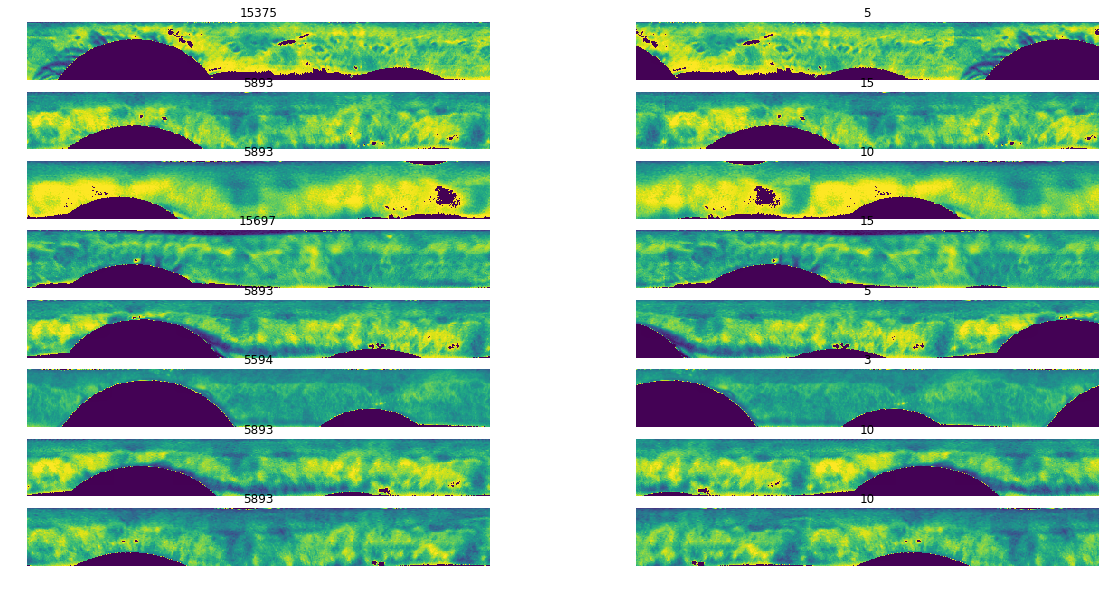

In [34]:
show_samples_from_tfr('../data/nd-iris-train-*.tfrecords')

In [19]:
input_img = Input(shape=(64, 512, 1))
# shape_input = Input(shape=(16,))
# shape_input_reshaped = Reshape((1, 1, 16))(shape_input)

x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(320, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(480, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)

x = BatchNormalization()(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Conv2D(480, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(320, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)


x = BatchNormalization()(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

# autoencoder = Model(inputs=[input_img, shape_input], outputs=decoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder = multi_gpu_model(autoencoder, gpus=4)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
get_train_generator = lambda: inputs(K.get_session(), '../data/nd-iris-train-*.tfrecords', 128, 100)
get_val_generator = lambda: inputs(K.get_session(), '../data/nd-iris-val-*.tfrecords', 128, 100)

In [ ]:
autoencoder.fit_generator(generator=get_train_generator(),
                epochs=100,
                steps_per_epoch=800, # batch size 256
                validation_data=get_val_generator(),
                validation_steps=190,
                workers = 0,
                use_multiprocessing=True,
                callbacks=[TensorBoard(log_dir='./iris_ae/deep_iris_net_2', write_images=True)])

Epoch 1/100
 32/800 [>.............................] - ETA: 18:56 - loss: 58.5426

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/data/ops/iterator_ops.py:316: UserWarning: An unusually high number of `Iterator.get_next()` calls was detected. This often indicates that `Iterator.get_next()` is being called inside a training loop, which will cause gradual slowdown and eventual resource exhaustion. If this is the case, restructure your code to call `next_element = iterator.get_next() once outside the loop, and use `next_element` inside the loop.
  warnings.warn(GET_NEXT_CALL_WARNING_MESSAGE)


800/800 [==============================] - 1113s 1s/step - loss: 20.9875 - val_loss: 1125.5350
Epoch 2/100
800/800 [==============================] - 1172s 1s/step - loss: 2.2544 - val_loss: 3.0909
Epoch 3/100
800/800 [==============================] - 1209s 2s/step - loss: 10.4122 - val_loss: 5.1899
Epoch 4/100
800/800 [==============================] - 1267s 2s/step - loss: 7.1977 - val_loss: 23.3210
Epoch 5/100
800/800 [==============================] - 1346s 2s/step - loss: 12.3962 - val_loss: 664.1671
Epoch 6/100
800/800 [==============================] - 1419s 2s/step - loss: 1.1995 - val_loss: 14.6772
Epoch 7/100
800/800 [==============================] - 1490s 2s/step - loss: 1.1951 - val_loss: 11.8238
Epoch 8/100
800/800 [==============================] - 1590s 2s/step - loss: 0.2561 - val_loss: 6.9701
Epoch 9/100
800/800 [==============================] - 1706s 2s/step - loss: 1.0163 - val_loss: 10.1888
Epoch 10/100
800/800 [==============================] - 1830s 2s/step - l

In [12]:
autoencoder.save('./iris_ae/4/test.hd5')

In [20]:
autoencoder.load_weights("./iris/deep_iris_net_3.14-13.84.hdf5")

In [21]:
# gen = get_train_generator()

# for (image, translation_vector), transformed in gen:
#     fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(20, 10))
#     decoded = autoencoder.predict([image, translation_vector])
#     for row in range(8):
#         axes[row, 0].axis("off")
#         axes[row, 1].axis("off")
#         axes[row, 2].axis("off")
#         axes[row, 0].imshow(image[row].reshape(64, 512))
#         axes[row, 0].set_title("Input")
#         axes[row, 1].imshow(transformed[row].reshape(64, 512))
#         axes[row, 1].set_title("Expected Output")
#         axes[row, 2].imshow(decoded[row].reshape(64, 512))
#         axes[row, 2].set_title("Reconstructed")
#     break

ValueError: not enough values to unpack (expected 2, got 1)

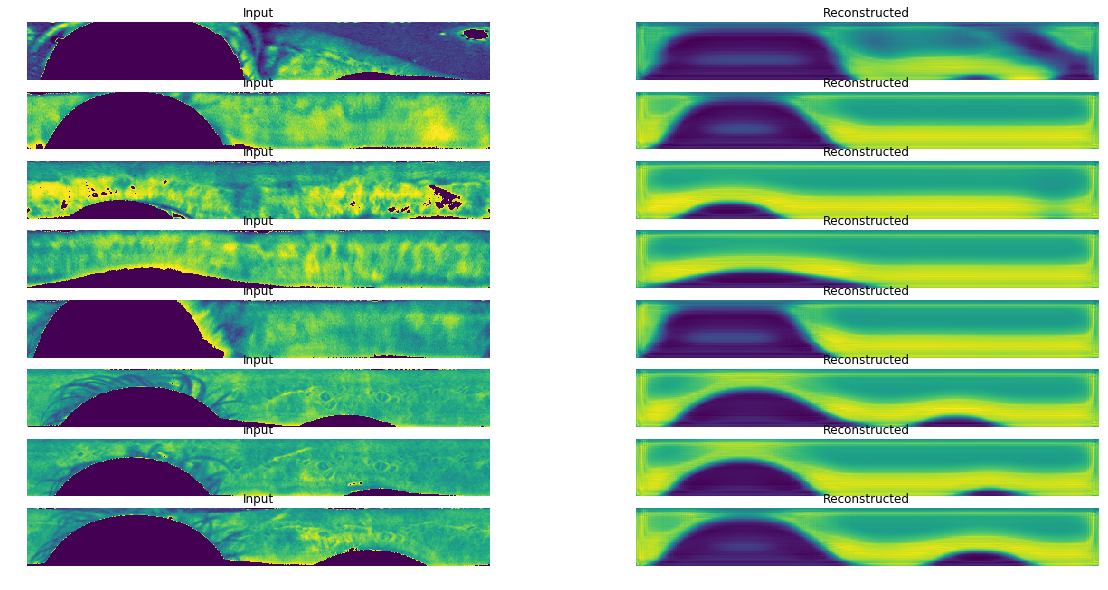

In [30]:
gen = get_train_generator()

for image, _ in gen:
    image = image[0]
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 10))
    decoded = autoencoder.predict(image)
    for row in range(8):
        axes[row, 0].axis("off")
        axes[row, 1].axis("off")
        axes[row, 0].imshow(image[row].reshape(64, 512))
        axes[row, 0].set_title("Input")
        axes[row, 1].imshow(decoded[row].reshape(64, 512))
        axes[row, 1].set_title("Reconstructed")
    break